# Pipeline

## Libraries

In [2]:
#general use and reading in the data
import os
import numpy as np
import pandas as pd

#Viz
import matplotlib.pyplot as plt
import seaborn as sns

#train test split
from sklearn.model_selection import train_test_split

#pipeline
from sklearn.pipeline import Pipeline

#transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

#GridSearchCV
from sklearn.model_selection import GridSearchCV

#cross validation
from sklearn.model_selection import cross_val_score

#models
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

#confusion matrix
from sklearn.metrics import confusion_matrix

#classification_report
from sklearn.metrics import classification_report

#precision recall curve
from sklearn.metrics import precision_recall_curve

#roc curve
from sklearn.metrics import roc_curve

#auc score
from sklearn.metrics import roc_auc_score

#average_precision_score
from sklearn.metrics import average_precision_score

## 1. Reading in the data

In [3]:
pwd = os.getcwd()
data = os.path.join(pwd, "data.csv")
df = pd.read_csv(data)

In [4]:
test =os.path.join(pwd, "test.csv")
df_test = pd.read_csv(test)
test_ids = df_test["PassengerId"]

## 2. Features and Target Selection

In [5]:
features = df[["Pclass", "Sex", "Fare"]]
target = df[["Survived"]]

In [19]:
features

,Survived
0,0
1,1
2,1
3,1
4,0
...,...
886,0
887,1
888,0
889,1


## 3. Spliting Data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(features,target, stratify=target, random_state=0)

## 4. Preprocessing and Pipeline

- Pipeline: during the call to *Pipline.fit*, the pipeline calls *fit* and then *transform* on each step in turn, with the input given by the output of the *transform* method of the previous step.
- for the last step in the pipeline. just *fit* is called

https://towardsdatascience.com/pipeline-columntransformer-and-featureunion-explained-f5491f815f

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

In [7]:
#preprocessing 
#step 1: define categorical and numerical columns
categorical = ["Pclass", "Sex"]
numerical = ["Fare"]

#step 2: create pipeline for grouped columns
#categorical pipeline
cat_pipe = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse=False))
])

#numerical pipeline
num_pipe = Pipeline([
    ("scaler", StandardScaler())
])

#columntransformer, binding grouped columns together
preprocessor = ColumnTransformer(
    transformers=[
        ("cat_pipe", cat_pipe, categorical),
        ("num_pipe", num_pipe, numerical)
    ]
)

#pipeline
pipe = Pipeline(
    steps=[
        ("preprocessor",preprocessor),
        ("classifier", SVC())
    ]
)

## 4.1 Accessing steps in pipeline

In [8]:
pipe.steps

[('preprocessor',
  ColumnTransformer(transformers=[('cat_pipe',
                                   Pipeline(steps=[('encoder',
                                                    OneHotEncoder(handle_unknown='ignore',
                                                                  sparse=False))]),
                                   ['Pclass', 'Sex']),
                                  ('num_pipe',
                                   Pipeline(steps=[('scaler', StandardScaler())]),
                                   ['Fare'])])),
 ('classifier', SVC())]

In [9]:
pipe.steps[0][1]

ColumnTransformer(transformers=[('cat_pipe',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Pclass', 'Sex']),
                                ('num_pipe',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Fare'])])

In [10]:
# pipe.fit(X_train, np.ravel(y_train))
# pipe.score(X_test, y_test)

## 5. Grid Search CV
1. parameters
2. GridSearchCV
3. .fit, .best_params_, .best_score_, .score(X_test, y_test)

In [11]:
param_grid = [
    #svc
    {
        "classifier":[SVC()],
        "preprocessor":[preprocessor],
        "classifier__C":[0.001, 0.01, 0.1, 1, 10, 100],
        "classifier__gamma":[0.001, 0.01, 0.1, 1, 10, 100]
    },
    #knn
    {
        "classifier":[KNeighborsClassifier()],
        "preprocessor":[preprocessor],
        "classifier__n_neighbors":[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    },
    #logreg
    {
        "classifier":[LogisticRegression()],
        "preprocessor":[preprocessor],
        "classifier__C":[0.001, 0.01, 0.1, 1, 10, 100]
    }
]

In [12]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, np.ravel(y_train))

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['Pclass',
                                                                          'Sex']),
                                                                        ('num_pipe',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                         

In [13]:
print(
    "Test-set score: {:5f}\n".format(grid.score(X_test, y_test))
)
print(
    "Best cross-validaiton score: {:.5f}".format(grid.best_score_)
)
print(
    "Best params:\n{}\n".format(grid.best_params_)
)
print(
    "Best best_estimator_: {}".format(grid.best_estimator_)
)

Test-set score: 0.780269

Best cross-validaiton score: 0.81430
Best params:
{'classifier': SVC(C=100, gamma=0.1), 'classifier__C': 100, 'classifier__gamma': 0.1, 'preprocessor': ColumnTransformer(transformers=[('cat_pipe',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Pclass', 'Sex']),
                                ('num_pipe',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Fare'])])}

Best best_estimator_: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_pipe',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                  

In [14]:
#grid.cv_results_ is a dictionary
#list(grid.cv_results_.keys())
cv_results = pd.DataFrame(grid.cv_results_)

Text(0.5, 1.0, 'SVC - GridSearchCV Heatmap')

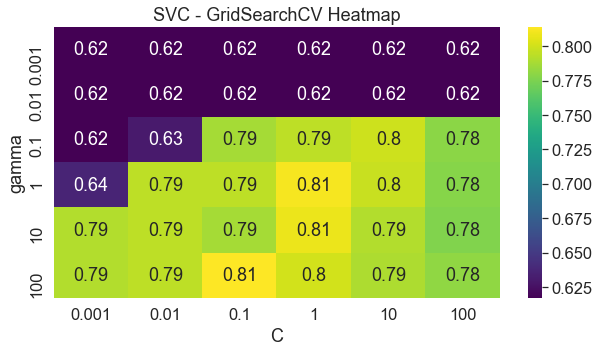

In [15]:
mean_test_score = np.array(cv_results[0:36]["mean_test_score"]).reshape(6,6)

plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)

sns.heatmap(
    mean_test_score,
    annot=True,
    cmap="viridis",
    xticklabels=param_grid[0]["classifier__C"],
    yticklabels=param_grid[0]["classifier__gamma"]
)

#titles, x,y-labels
plt.xlabel("C")
plt.ylabel("gamma")
plt.title("SVC - GridSearchCV Heatmap")

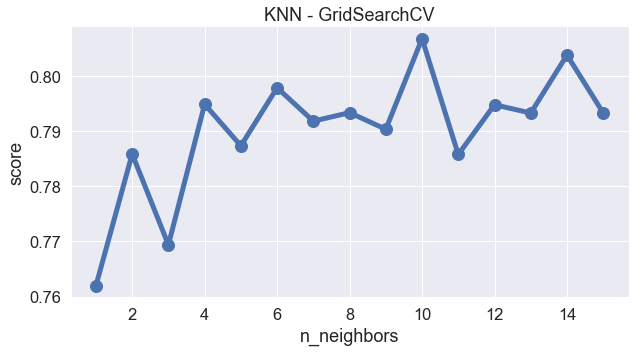

In [16]:
plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)

plt.plot(
    cv_results[36:51]["param_classifier__n_neighbors"],
    cv_results[36:51]["mean_test_score"],
    linewidth=5,
    marker="o",
    markersize=12
)

plt.xlabel("n_neighbors")
plt.ylabel("score")
plt.title("KNN - GridSearchCV")
plt.show()

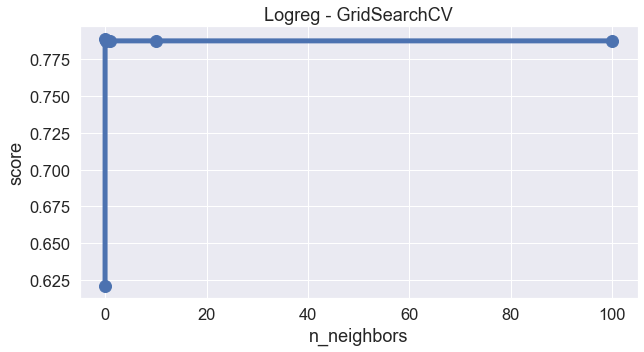

In [17]:
plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)

plt.plot(
    cv_results[51:57]["param_classifier__C"],
    cv_results[51:57]["mean_test_score"],
    linewidth=5,
    marker="o",
    markersize=12
)

plt.xlabel("n_neighbors")
plt.ylabel("score")
plt.title("Logreg - GridSearchCV")
plt.show()

In [18]:
nested = cross_val_score(
    GridSearchCV(pipe, param_grid=param_grid, cv=5),
    features, np.ravel(target), cv=5
)

In [20]:
nested.mean()

0.7991525955683887

## Confusion Matrix

In [21]:
X_train_fit_trans = preprocessor.fit_transform(X_train)
X_test_fit_trans = preprocessor.fit_transform(X_test)


In [22]:
svc = SVC(C=100, gamma=0.1)
svc.fit(X_train_fit_trans, np.ravel(y_train))
pred_svc = svc.predict(X_test_fit_trans)
confusion_svc = confusion_matrix(y_test, pred_svc)

In [23]:
confusion_svc

array([[124,  13],
       [ 34,  52]])

In [24]:
# X_test.reset_index().rename({"index":"PassengerID"}, axis=1)


# # df.rename(
# #     {'a': 'X', 'b': 'Y'}, 
# #     axis=1
# #     )

In [25]:
# pred_survived = pd.DataFrame(pred_svc)
# # pd.concat([X_test, pred_survived], axis=1)
# X_test

In [26]:
target_names=['dead','survived']

print(
    classification_report(y_test, pred_svc, target_names=target_names)
)

              precision    recall  f1-score   support

        dead       0.78      0.91      0.84       137
    survived       0.80      0.60      0.69        86

    accuracy                           0.79       223
   macro avg       0.79      0.75      0.76       223
weighted avg       0.79      0.79      0.78       223



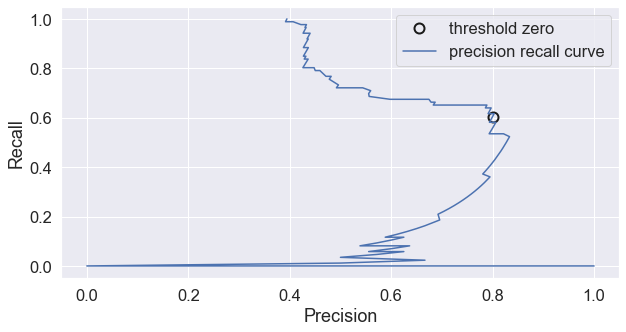

In [27]:
plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)

precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test_fit_trans))

close_zero = np.argmin(np.abs(thresholds))

plt.plot(
    precision[close_zero],
    recall[close_zero],
    "o",
    markersize=10,
    label="threshold zero",
    fillstyle="none",
    c="k",
    mew=2
)

plt.plot(precision, recall, label="precision recall curve")

plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

In [28]:
ap_svc = average_precision_score(y_test, svc.decision_function(X_test_fit_trans))
print(
    "Average precision of svc:     {:.3f}".format(ap_svc)
)

Average precision of svc:     0.644


## ROC AUC curves

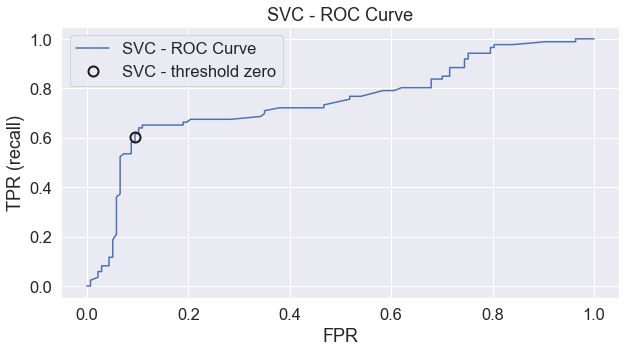

In [29]:
#SVC

plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)

fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test_fit_trans))

plt.plot(fpr, tpr, label="SVC - ROC Curve")

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.title("SVC - ROC Curve")

close_zero_svc = np.argmin(np.abs(thresholds))

plt.plot(fpr[close_zero_svc],tpr[close_zero_svc],"o", markersize=10,label="SVC - threshold zero", fillstyle="none", c="k", mew=2)
plt.legend(loc="best")

In [30]:
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test_fit_trans))
print(
    "AUC for SVC:    {:.3f}".format(svc_auc)
)

AUC for SVC:    0.748


## Submission

In [31]:
X_test_sub = df_test[["Pclass", "Sex","Fare"]]
X_test_sub_trans = preprocessor.transform(X_test_sub)

from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_test_sub_trans_imp = imp.fit_transform(X_test_sub_trans)


In [32]:
clf = SVC(C=100, gamma=0.1)
clf.fit(X_train_fit_trans, np.ravel(y_train))

SVC(C=100, gamma=0.1)

In [33]:
submission_pred = clf.predict(X_test_sub_trans_imp)

In [34]:
df_submit = pd.DataFrame(
    {
    "PassengerId":test_ids.values,
    "Survived":submission_pred
    }
)

In [35]:
df_submit.to_csv("submission.csv", index=False)